In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE =32
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle =True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    
 )

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

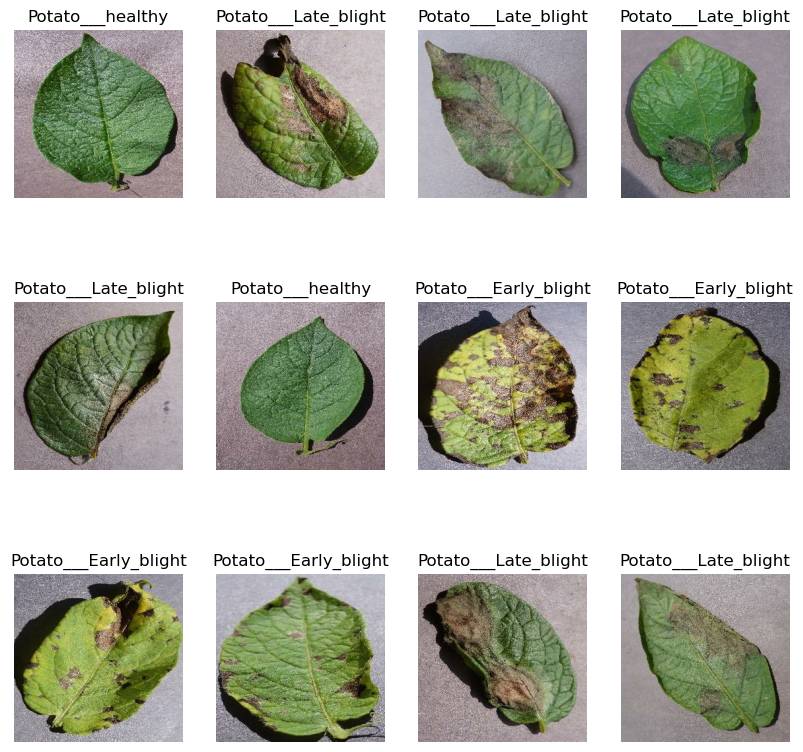

In [6]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

# 80% ==> training
# 20% ==> 10% validation , 10% test

In [8]:
train_size =0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)


In [10]:
rest_ds = dataset.skip(54)

In [11]:
val_ds = rest_ds.take(6)

In [12]:
test_ds = rest_ds.skip(6)

In [13]:
def get_dataset_partition_tf(ds,train_split =0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size =len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds ,val_ds , test_ds

In [14]:
train_ds,val_ds,test_ds = get_dataset_partition_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
#optimized fro training performance
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
    
])

In [20]:
data_augmentation = tf.keras.Sequential([
     tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(0.2)
])

# building a model

In [22]:
input_shape =(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes =3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation ='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation ='relu'),
    layers.Dense(n_classes,activation='softmax')
 ])

model.build(input_shape = input_shape)

C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 2304)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose =1,
    validation_data = val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.4827 - loss: 0.9347 - val_accuracy: 0.6927 - val_loss: 0.6653
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.7568 - loss: 0.5542 - val_accuracy: 0.8490 - val_loss: 0.2823
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8965 - loss: 0.2607 - val_accuracy: 0.8698 - val_loss: 0.2628
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.9112 - loss: 0.2218 - val_accuracy: 0.9323 - val_loss: 0.1630
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9422 - loss: 0.1460 - val_accuracy: 0.9479 - val_loss: 0.1252
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9509 - loss: 0.1229 - val_accuracy: 0.8958 - val_loss: 0.2325
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9404 - loss: 0.1399 - val_accuracy: 0.9271 - val_loss: 0.2450
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9211 - loss: 0.2099 - val_accuracy: 0.9219 - v

In [26]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 582ms/step - accuracy: 0.9344 - loss: 0.1673


In [27]:
scores

[0.12348872423171997, 0.94921875]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

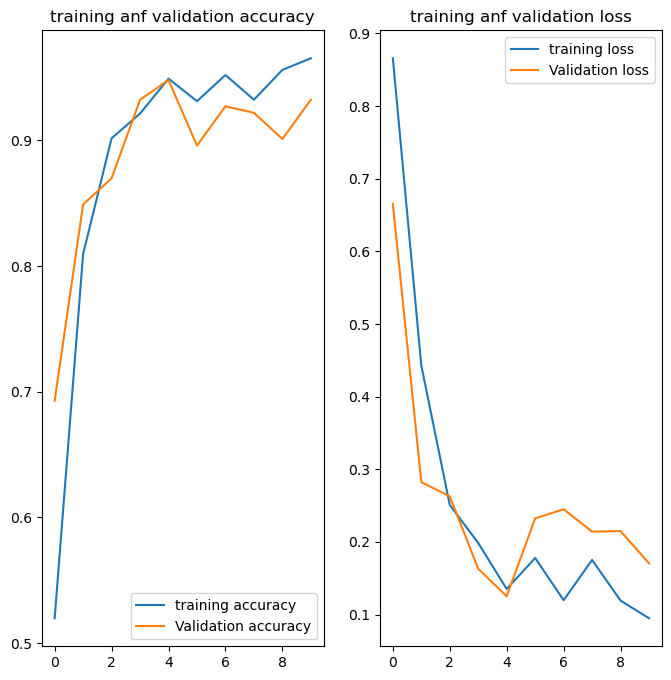

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="training accuracy")
plt.plot(range(EPOCHS),val_acc,label = "Validation accuracy")
plt.legend(loc = 'lower right')
plt.title("training anf validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="training loss")
plt.plot(range(EPOCHS),val_loss,label = "Validation loss")
plt.legend(loc = 'upper right')
plt.title("training anf validation loss")
plt.show()

first image to predict
actual label:  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted_label :  Potato___Early_blight


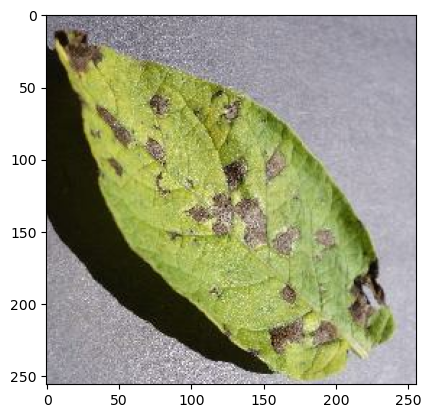

In [33]:
for image_batch ,labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_name[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted_label : ",class_name[np.argmax(batch_prediction[0])])

In [34]:
def predict(model ,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # creates a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


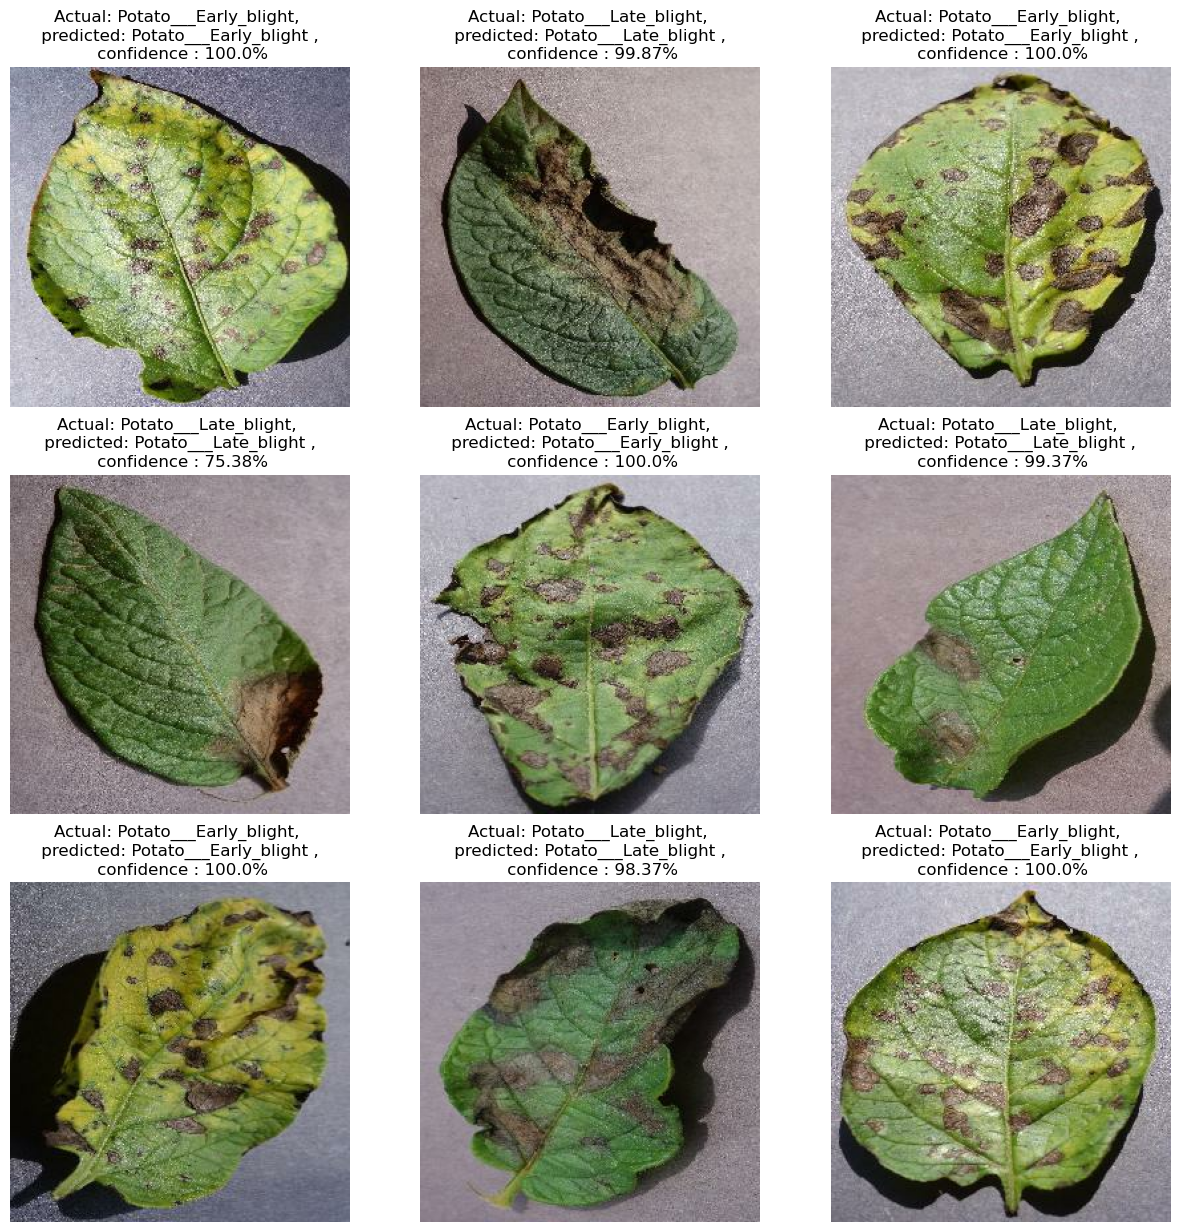

In [35]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_name[labels[i]]
        plt.title(f"Actual: {actual_class}, \n predicted: {predicted_class} , \n confidence : {confidence}%")
        plt.axis('off')

In [36]:
model.save("model.h5")